# House sales prices in King County

A project on exploratory data analysis.

Sebastian Thomas @ neue fische Bootcamp Data Science<br />
(datascience at sebastianthomas dot de)

# Part 3: Feature engineering

We engineer some new features for the cleaned data set.

## Imports

### Modules, classes and functions

In [1]:
# python object persistence
import joblib

# data
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

# custom modules
from modules.ds import data_type_info, logarithmize_features, bin_features, coarsen_categories, reindex_columns
from transformer.feature_engineering import engineer_king_county

We set the options to print all columns and to print float columns with two decimals.

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

### Helpers

Some helping functions for exploration.

In [3]:
def print_unique_values(feature):
    '''Prints the unique values of feature of the houses data set.'''
    print(np.sort(houses_train[feature].unique()))

def print_number_of_unique_values(feature):
    '''Prints the number of unique values of feature of the houses data set.'''
    print(houses_train[feature].nunique())

def plot_hist(feature):
    '''Plots a histogram of feature.'''
    plt.figure(figsize=(20, 5), dpi=300)
    sns.distplot(houses_train[feature], kde=False)
    plt.show()

def plot_box(feature='price', group_by=None, restricted=False):
    '''Plots a boxplot of feature.'''
    plt.figure(figsize=(20, houses_train[group_by].unique().size*2.5 if group_by is not None else 5),
               dpi=300)
    ax = sns.boxplot(x=feature, y=group_by, data=houses_train, orient='h')
    if restricted:
        ax.set_xlim(whiskers(houses_train[feature]))
    plt.show()
    
def plot_dist(feature, vertical=False):
    '''Plots distribution of feature as boxplot and histogram.'''
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(20, 10), dpi=300)
    sns.boxplot(houses_train[feature], ax=ax[0])
    sns.distplot(houses_train[feature], kde=False)
    ax[0].get_xaxis().set_visible(False)
    if vertical:
        ax[1].set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

def plot_count(feature, ordered=False, vertical=False):
    '''Plots a countplot of feature.'''
    plt.figure(figsize=(20, 5), dpi=300)
    order = houses_train.groupby(feature)[feature].count().sort_values().index if ordered else None
    ax = sns.countplot(x=feature, data=houses_train, order=order)
    if vertical:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

def plot_scatter(feature, target='price'):
    '''Plots a scatter plot of feature against \'price\'.'''
    plt.figure(figsize=(20, 5), dpi=300)
    sns.scatterplot(x=feature, y=target, data=houses_train)
    plt.show()

def plot_bar_medians(feature='price', group_by=None, ordered=False, vertical=False):
    '''Plots median(s) as bar plot.'''
    plt.figure(figsize=(20, 5), dpi=300)
    order = houses_train.groupby(group_by)[feature].median().sort_values().index if ordered else None
    ax = sns.barplot(x=group_by, y=feature, data=houses_train, order=order, estimator=np.median)
    if vertical:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

def plot_bar_log_medians(feature='price', group_by=None, ordered=False, vertical=False):
    '''Plots median(s) as bar plot.'''
    plt.figure(figsize=(20, 5), dpi=300)
    order = houses_train.groupby(group_by)[feature].median().sort_values().index if ordered else None
    ax = sns.barplot(x=group_by, y=feature, data=houses_train, order=order,
                     estimator=(lambda x: np.log(np.median(x))))
    if vertical:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.show()

### Data

In [4]:
houses_train = pd.read_pickle('data/king_county_train_1_cleaned.pickle')
features = pd.read_pickle('data/features.pickle')

houses_train.sample(5, random_state=0)

,price,date,sqft_living,sqft_above,sqft_basement,sqft_lot,sqft_living15,sqft_lot15,bedrooms,bathrooms,floors,yr_built,yr_renovated,lat,long,zipcode,condition,grade,view,waterfront
id,,,,,,,,,,,,,,,,,,,,
8724300010,"548,000.00",2014-09-09,"3,420.00","2,330.00","1,090.00","5,012.00","2,320.00","5,465.00",4,3.25,2.00,2008,2008,47.73,-121.98,98019,3,10,0,False
1423400005,"249,950.00",2014-08-15,"1,370.00","1,370.00",0.00,"11,658.00","1,080.00","9,198.00",3,1.00,1.00,1958,1958,47.46,-122.18,98058,4,6,0,False
7202330280,"401,000.00",2014-09-22,"1,350.00","1,350.00",0.00,"2,839.00","1,650.00","3,093.00",3,2.25,2.00,2003,2003,47.68,-122.04,98053,3,7,0,False
1828000230,"498,000.00",2014-07-14,"1,620.00","1,180.00",440.00,"8,400.00","2,120.00","8,424.00",3,2.00,1.00,1968,1968,47.66,-122.13,98052,3,7,0,False
3342100995,"449,000.00",2014-10-22,"1,980.00","1,980.00",0.00,"5,400.00","1,980.00","5,400.00",4,2.50,2.00,1998,1998,47.52,-122.21,98056,3,8,0,False


## Feature Engineering

### `'month'`: month (and year) when object was sold

We introduce a feature `'month'` that indicates in which month (and year) an object was sold.

### `'room_size'`: estimator for the mean room size of an object

We introduce a feature `'room_size'` that estimates the mean room size of an object. It is defined as the ratio of the feature `'sqft_living'` by the sum of the feature `'bathrooms'`, the feature `'bedrooms'` and 1.

### `'base_area'`: estimator for the base area of an object

We introduce a feature `'base_area'` that estimates the base area of an object. It is defined as the ratio of the feature `'sqft_above'` by the feature `'floors'`.

### `'has_basement'`: indicator for a finished basement

We introduce a feature `'has_basement'` that indicates whether an object has a finished basement. It is defined by the sign of the feature `'sqft_basement'`.

### `'bathrooms_ratio'`: estimator for the bath share of an object

We introduce a feature `'bathrooms_ratio'` that estimates the bath share of an object. It is defined as the ratio of the feature `'bathrooms'` by the feature `'bedrooms'`.

### `'is_renovated'`: indicator for a renovated object

We introduce a feature `'is_renovated'` that indicates whether an object has been renovated in the last 20 years.

### Engineerer

We engineer the aforementioned features, using a predefined function `engineer_king_county`.

In [5]:
engineerer = FunctionTransformer(engineer_king_county)

houses_train = engineerer.transform(houses_train)

## Logarithmizing

### `'sqft_living log'`: logarithm of interior housing living space

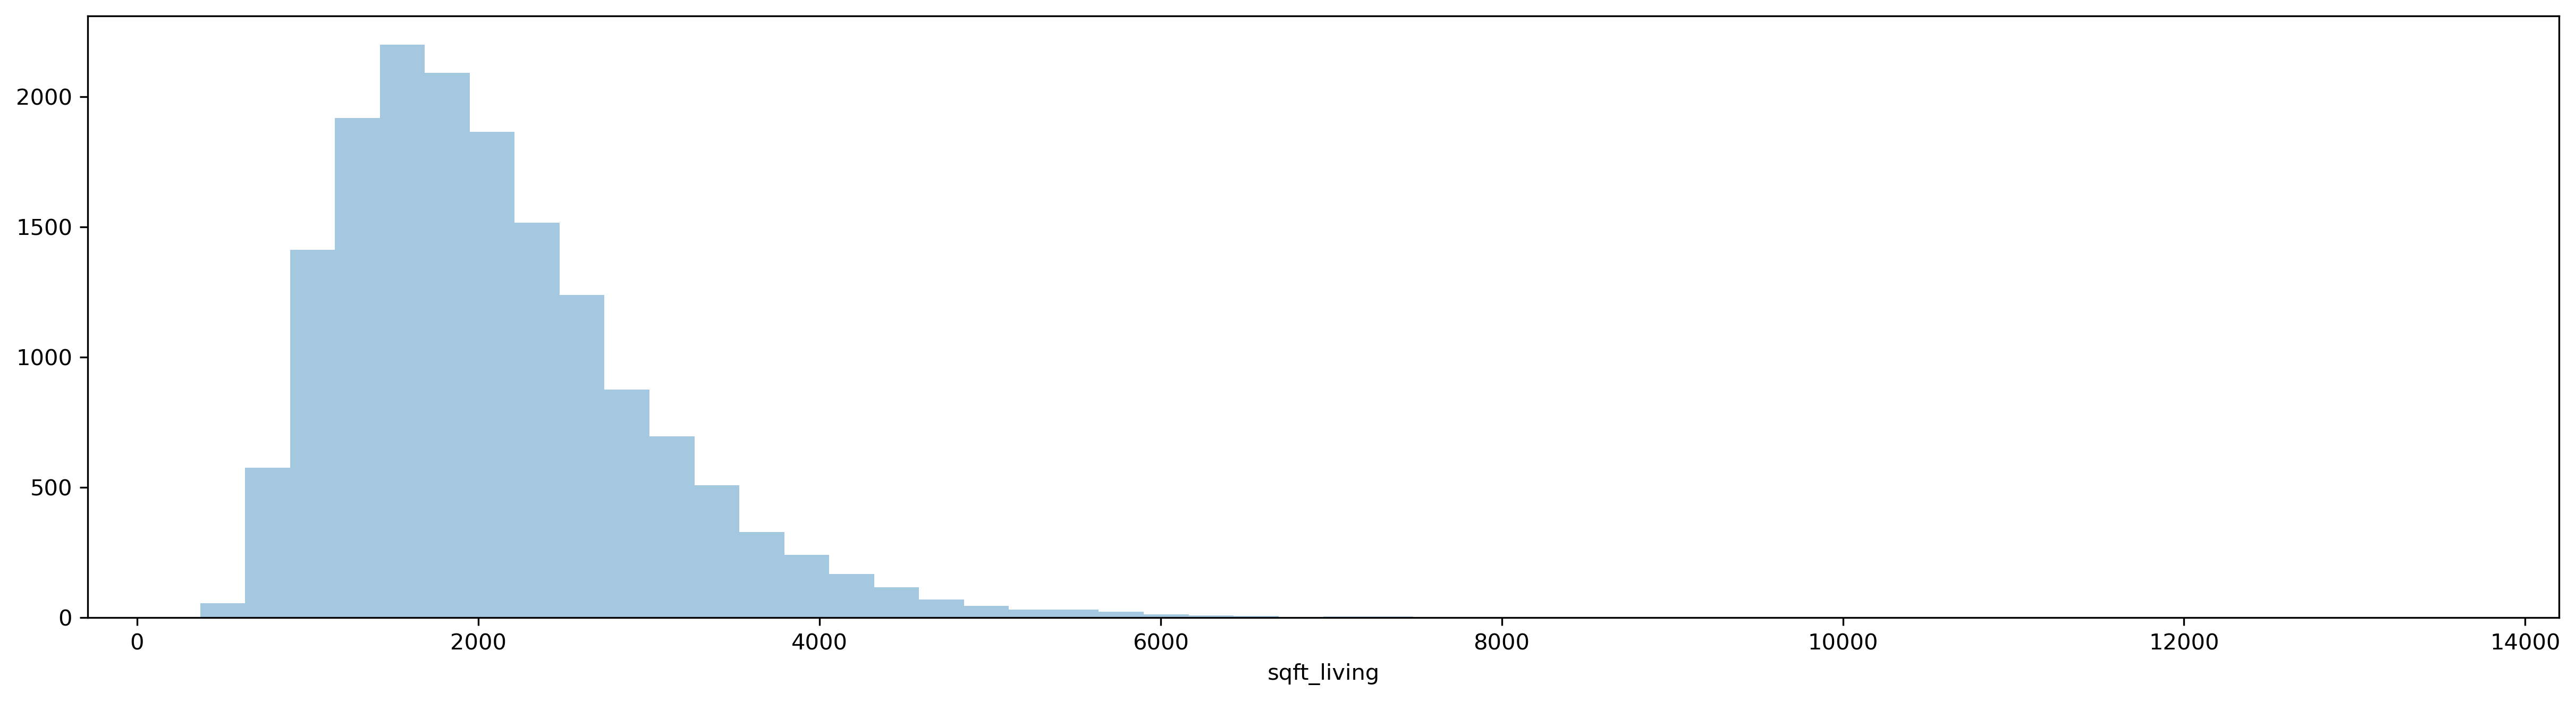

In [6]:
plot_hist('sqft_living')

The distribution of the feature `'sqft_living'` is left modal. We engineer a new feature `'sqft_living log'` by logarithmization.

### `'sqft_above log'`: logarithm of house area apart from basement

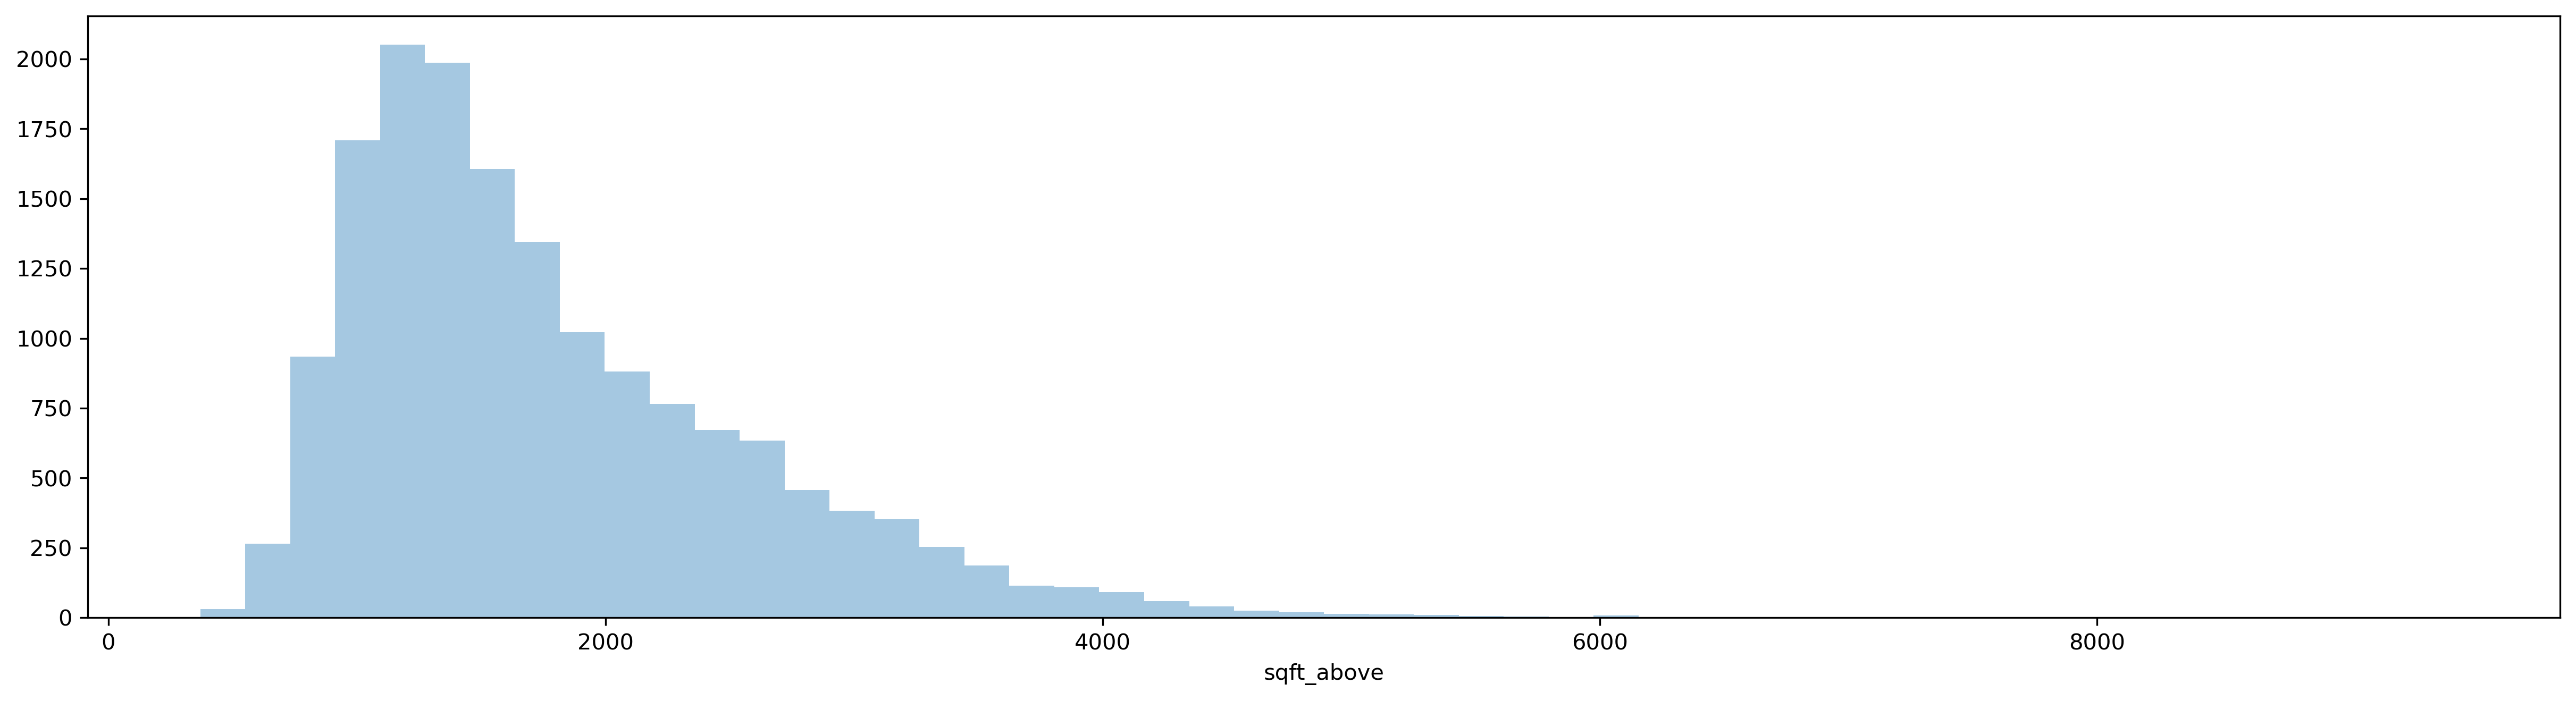

In [7]:
plot_hist('sqft_above')

The distribution of the feature `'sqft_above'` is left modal. We engineer a new feature `'sqft_above log'` by logarithmization.

### `'room_size log'`: estimator for logarithm of mean room size

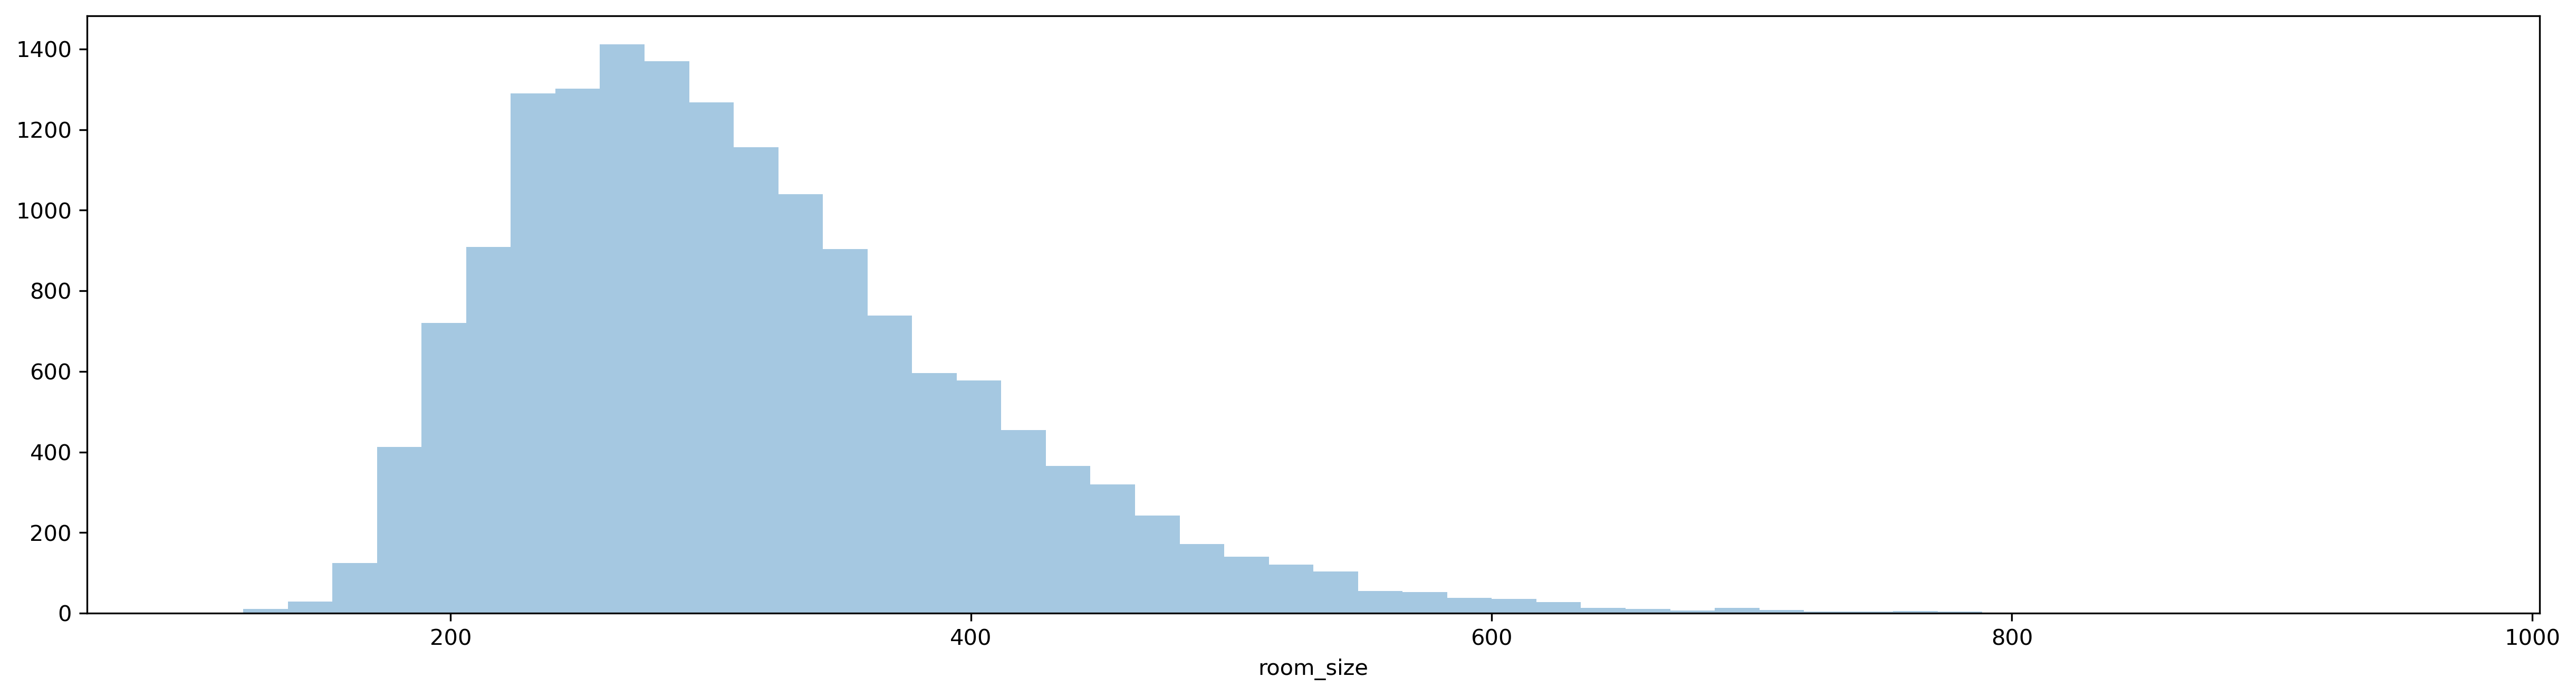

In [8]:
plot_hist('room_size')

The distribution of the feature `'room_size'` is left modal. We engineer a new feature `'room_size log'` by logarithmization.

### `'base_area log'`: estimator for logarithm of base area

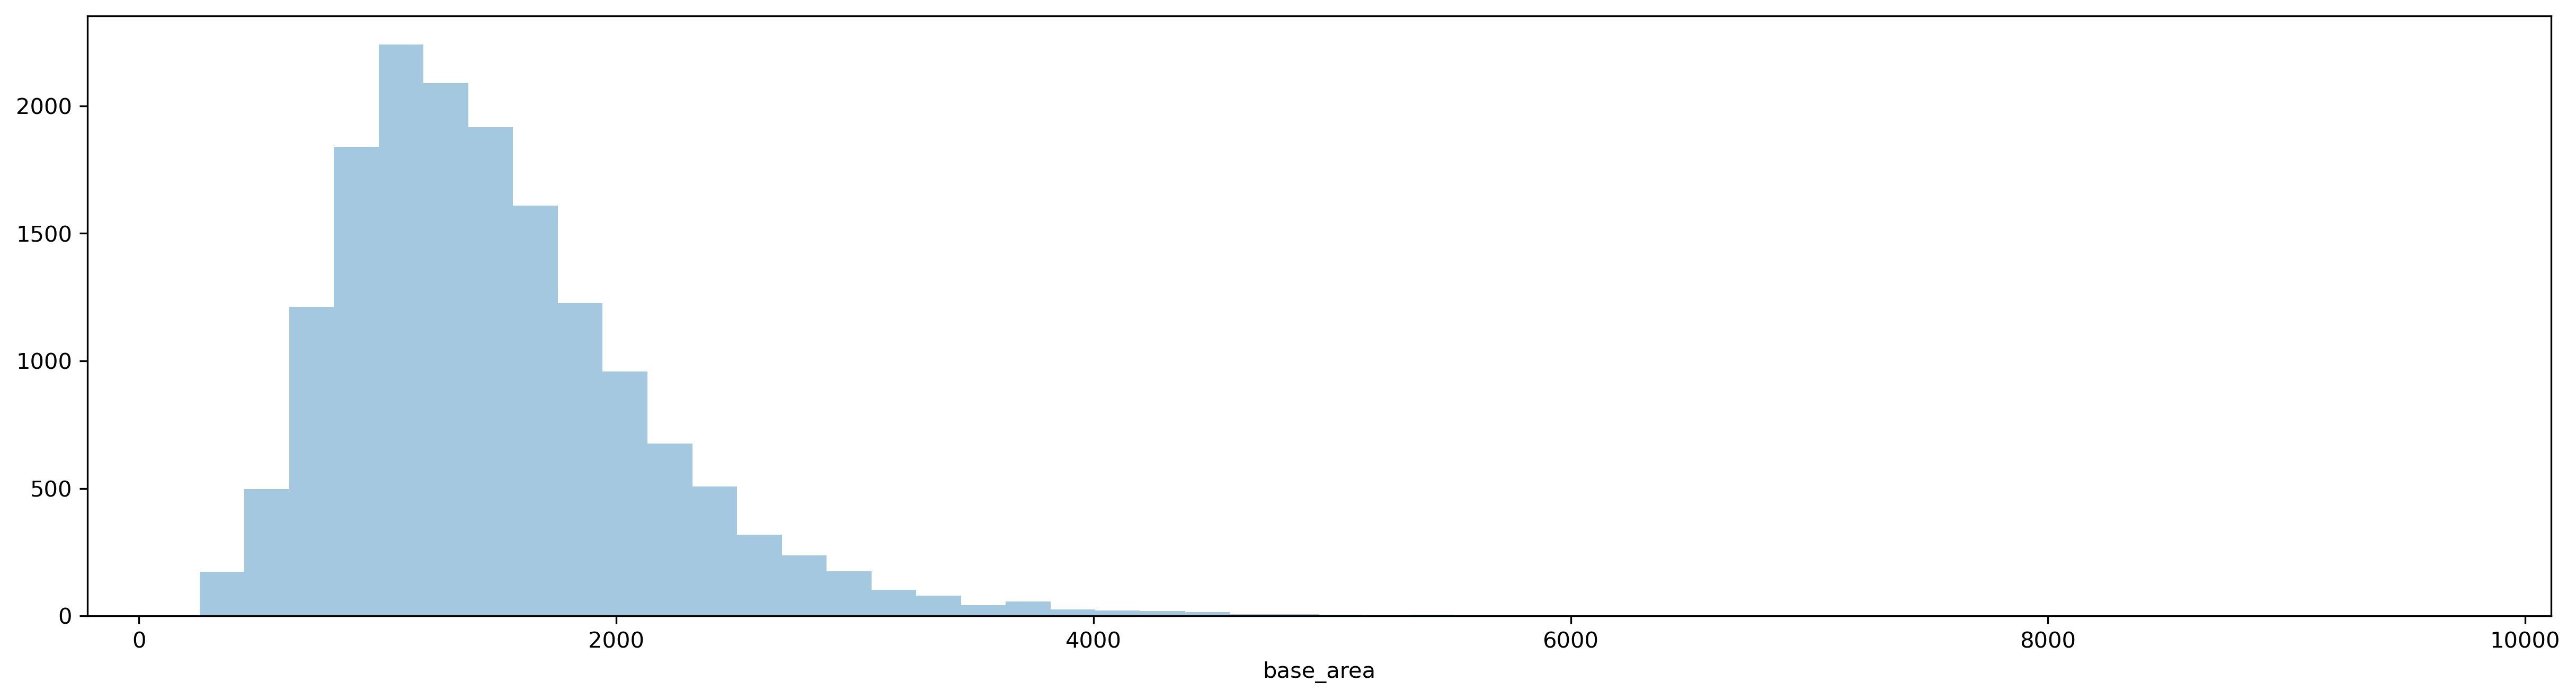

In [9]:
plot_hist('base_area')

The distribution of the feature `'base_area'` is left modal. We engineer a new feature `'base_area log'` by logarithmization.

### `'sqft_living15 log'`: logarithm of interior housing living space of nearest 15 neighbours

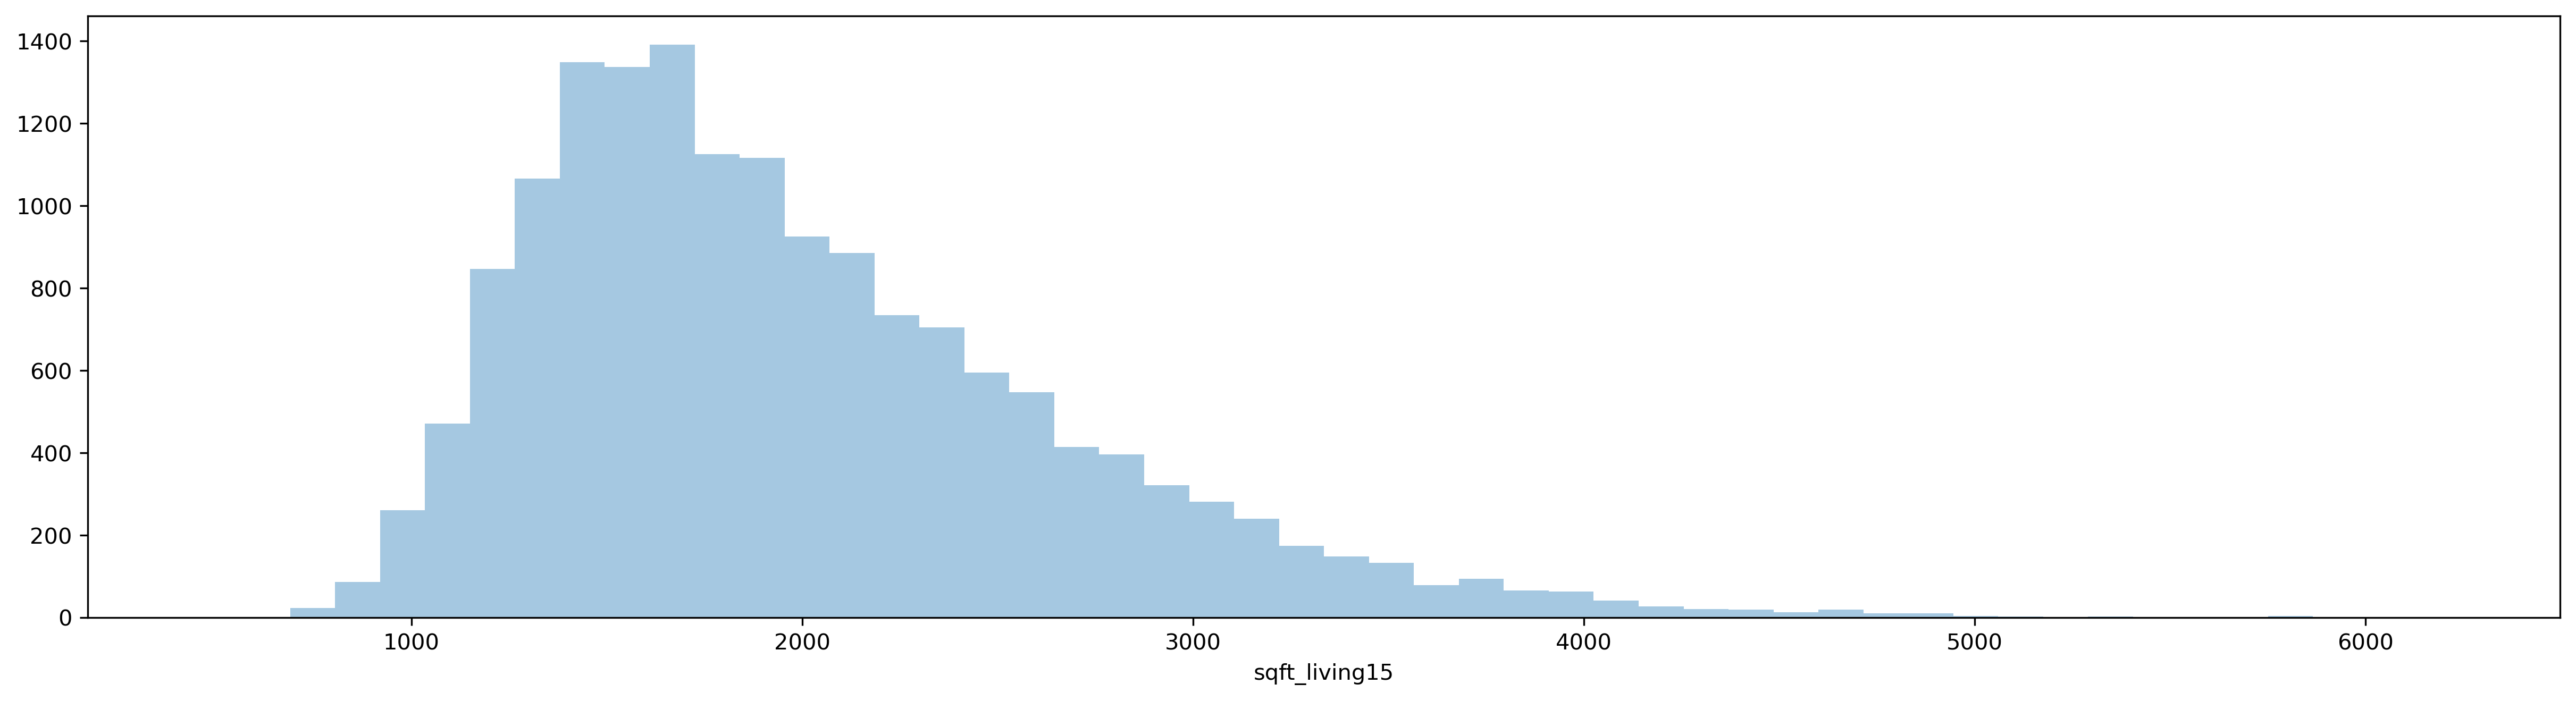

In [10]:
plot_hist('sqft_living15')

The distribution of the feature `'sqft_living15'` is left modal. We engineer a new feature `'sqft_living15 log'` by logarithmization.

### Logarithmizer

In [11]:
to_be_logarithmized = ['sqft_living', 'sqft_above', 'sqft_basement', 'room_size', 'base_area', 'sqft_living15']

logarithmizer = FunctionTransformer(logarithmize_features, kw_args={'to_be_logarithmized': to_be_logarithmized})

houses_train = logarithmizer.transform(houses_train)

## Binning

### `'bedrooms bin'`: binning of `'bedrooms'`

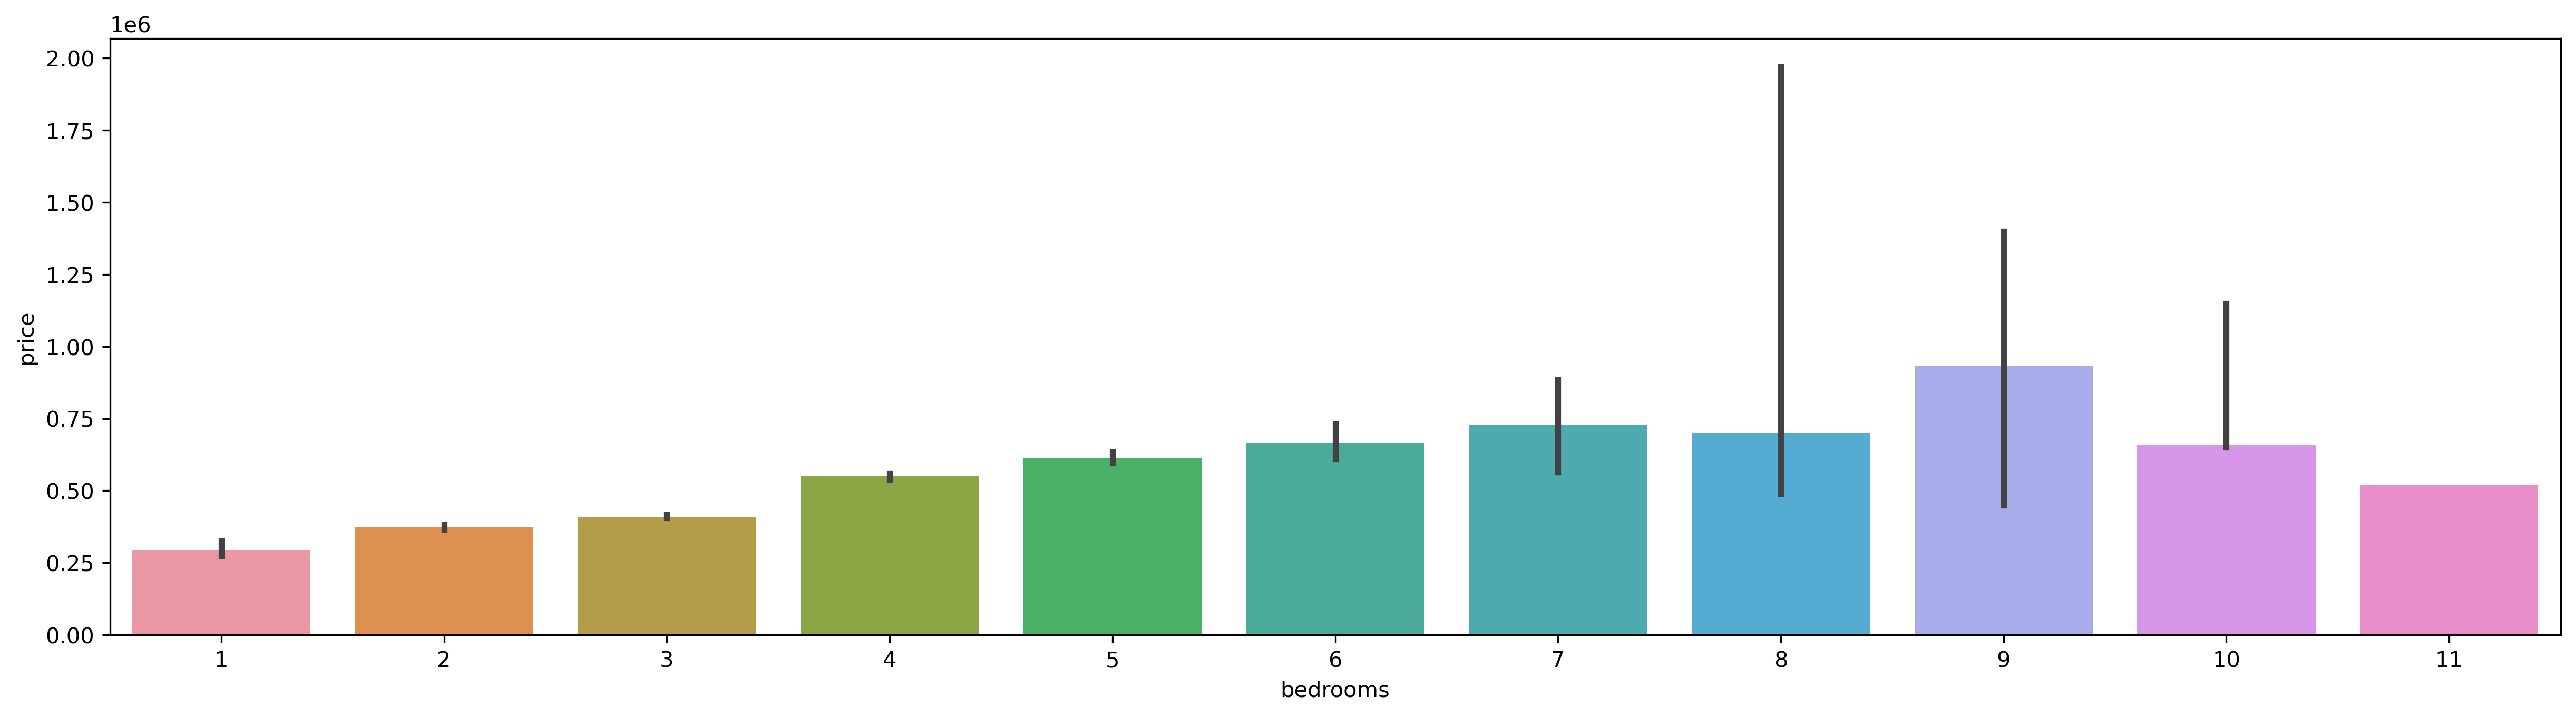

In [12]:
plot_bar_medians(group_by='bedrooms')

We engineer a new feature `'bedrooms bin'` by combining the values from 6 to 11.

In [13]:
bedrooms_bins = [0, 1, 2, 3, 4, 5, 11]
bedrooms_labels = ['1', '2', '3', '4', '5', '6 to 11']

### `'bathrooms bin'`: binning of `'bathrooms'`

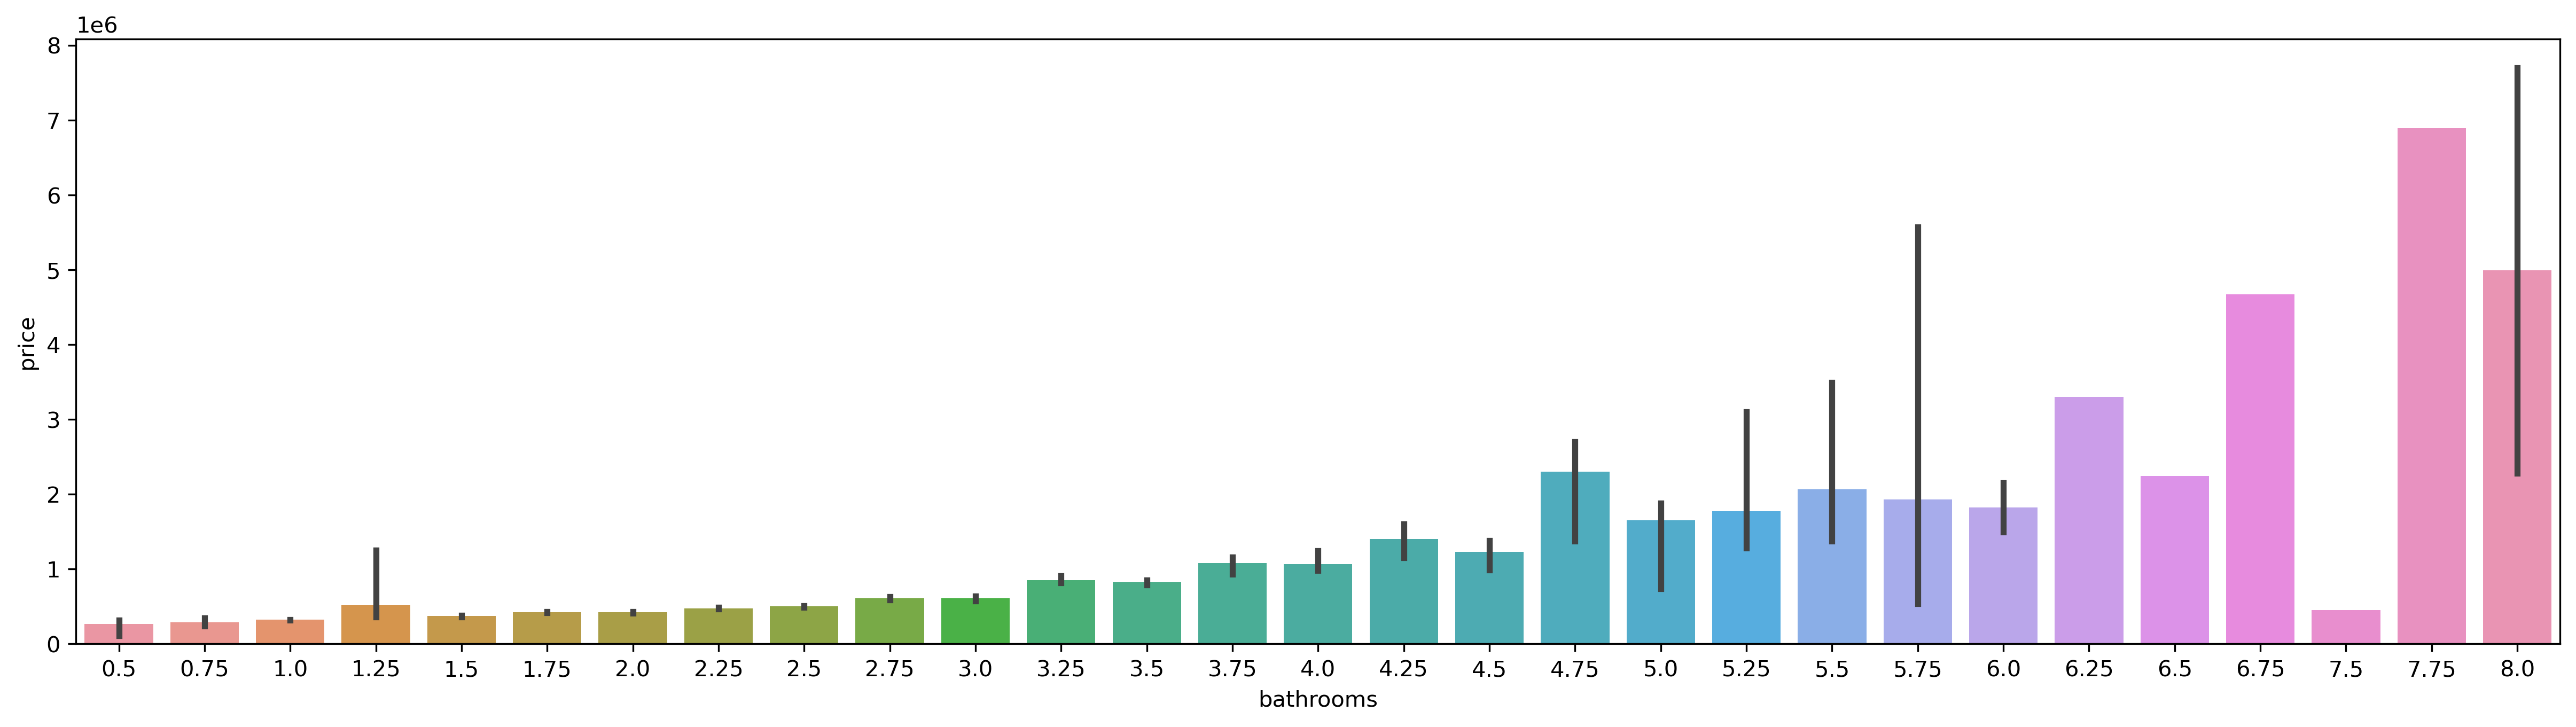

In [14]:
plot_bar_medians(group_by='bathrooms')

We engineer a new feature `'bathrooms bin'` by binning.

In [15]:
bathrooms_bins = [0, 0.5, 1, 2, 3, 3.5, 4.5, 7.5, 8.0]
bathrooms_labels = ['0.5', '0.75 to 1', '1.25 to 2', '2.25 to 3', '3.25 to 3.5', '3.75 to 4.5', '4.75 to 7.5',
                    '7.75 to 8']

### `'bathrooms_ratio bin'`: binning of `'bathrooms_ratio'`

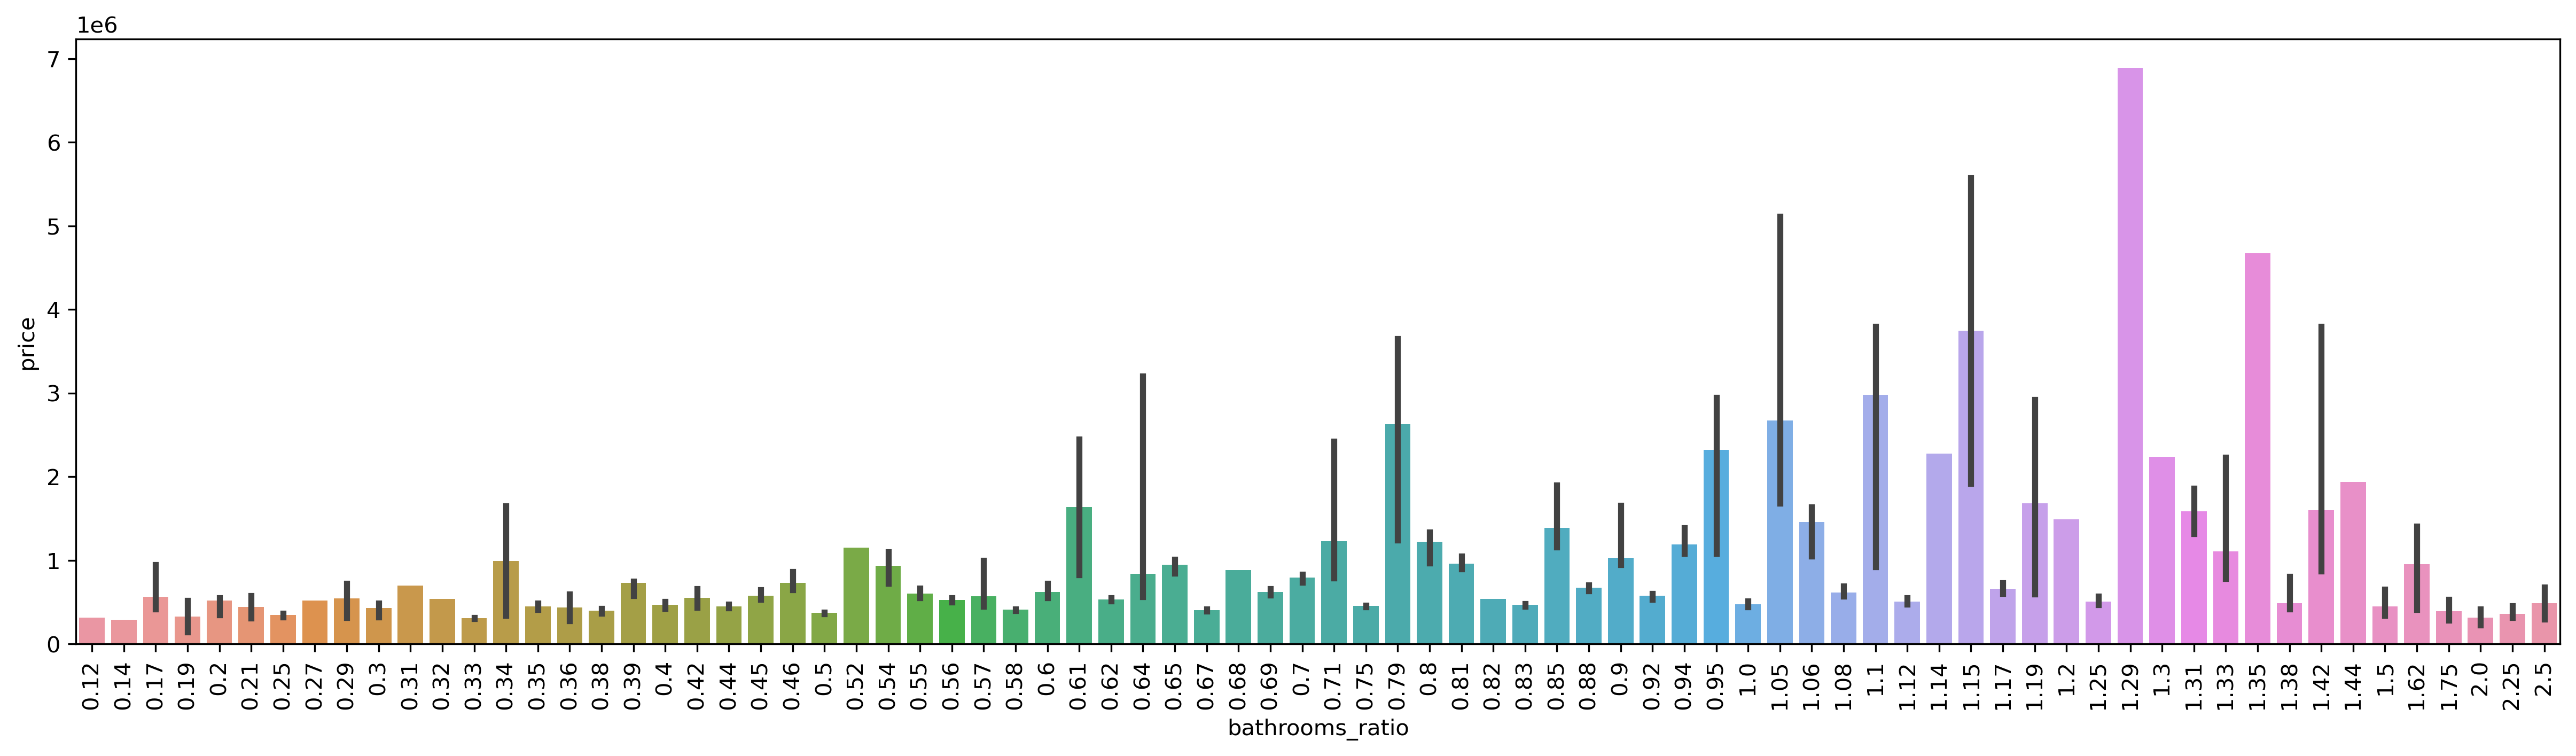

In [16]:
plot_bar_medians(group_by=np.round(houses_train['bathrooms_ratio'], 2), vertical=True)

We engineer a new feature `'bathrooms_ratio bin'` by binning.

In [17]:
bathrooms_ratio_bins = [0.000, 0.345, 0.615, 0.795, 1.160, 1.650, 3.000]
bathrooms_ratio_labels = ['0.000 to 0.345', '0.345 to 0.615', '0.615 to 0.795', '0.795 to 1.160',
                          '1.160 to 1.650', '1.650 to 3.000']

### `'floors bin'`: binning of `'floors'`

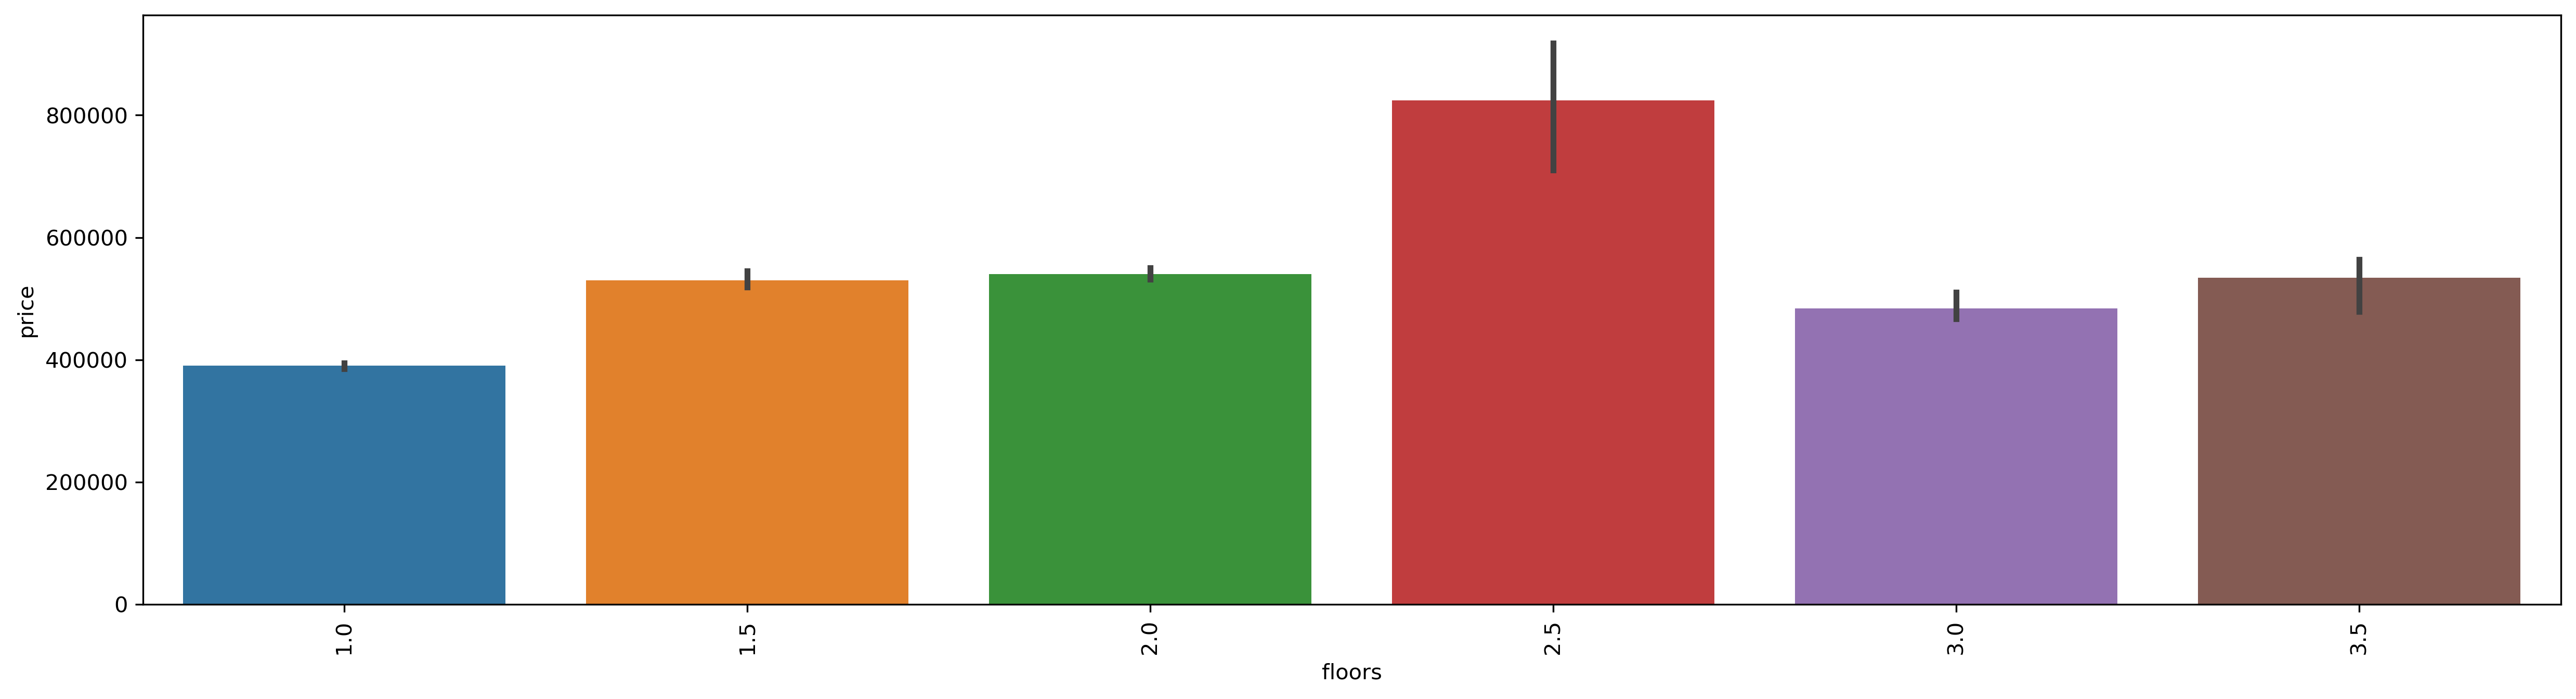

In [18]:
plot_bar_medians(group_by='floors', vertical=True)

We engineer a new feature `'floors bin'` by binning.

In [19]:
floors_bins = [0, 1, 2, 2.5, 3.5]
floors_labels = ['1.0', '1.5 to 2.0', '2.5', '2.5 to 3.5']

### `'decade_built'` and `'yr_built_bin'`: binnings of `'yr_built'`

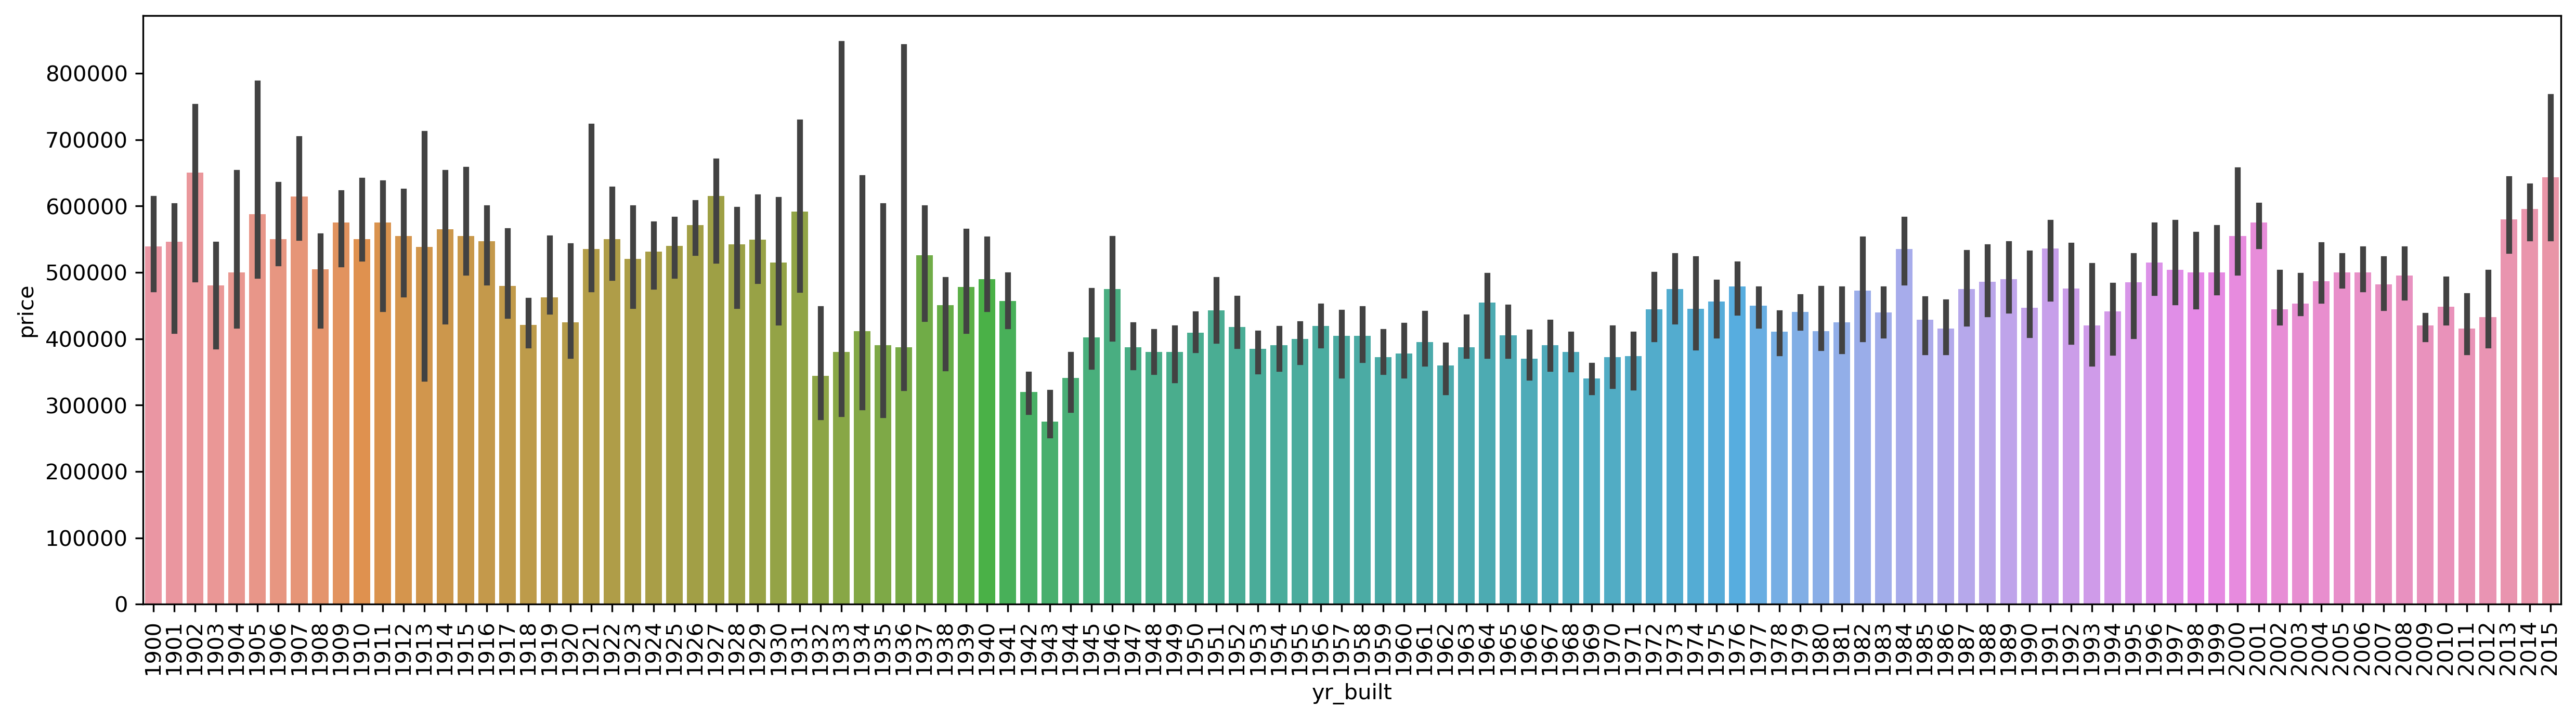

In [20]:
plot_bar_medians(group_by='yr_built', vertical=True)

We engineer a new feature `'decade built'` by binning.

In [21]:
decade_bins = [1899 + i*10 for i in range(13)]
decade_labels = ['{}0s'.format(bin // 10) for bin in decade_bins[1:]]

We engineer a new feature `'yr_built bin'` by binning.

In [22]:
yr_built_bins = [1899, 1931, 1971, 1991, 2001, 2012, 2015]
yr_built_labels = ['1900 to 1931', '1932 to 1971', '1972 to 1991', '1992 to 2001',
                   '2002 to 2012', '2013 to 2015']

### `'condition bin'`: binning of `'condition'`

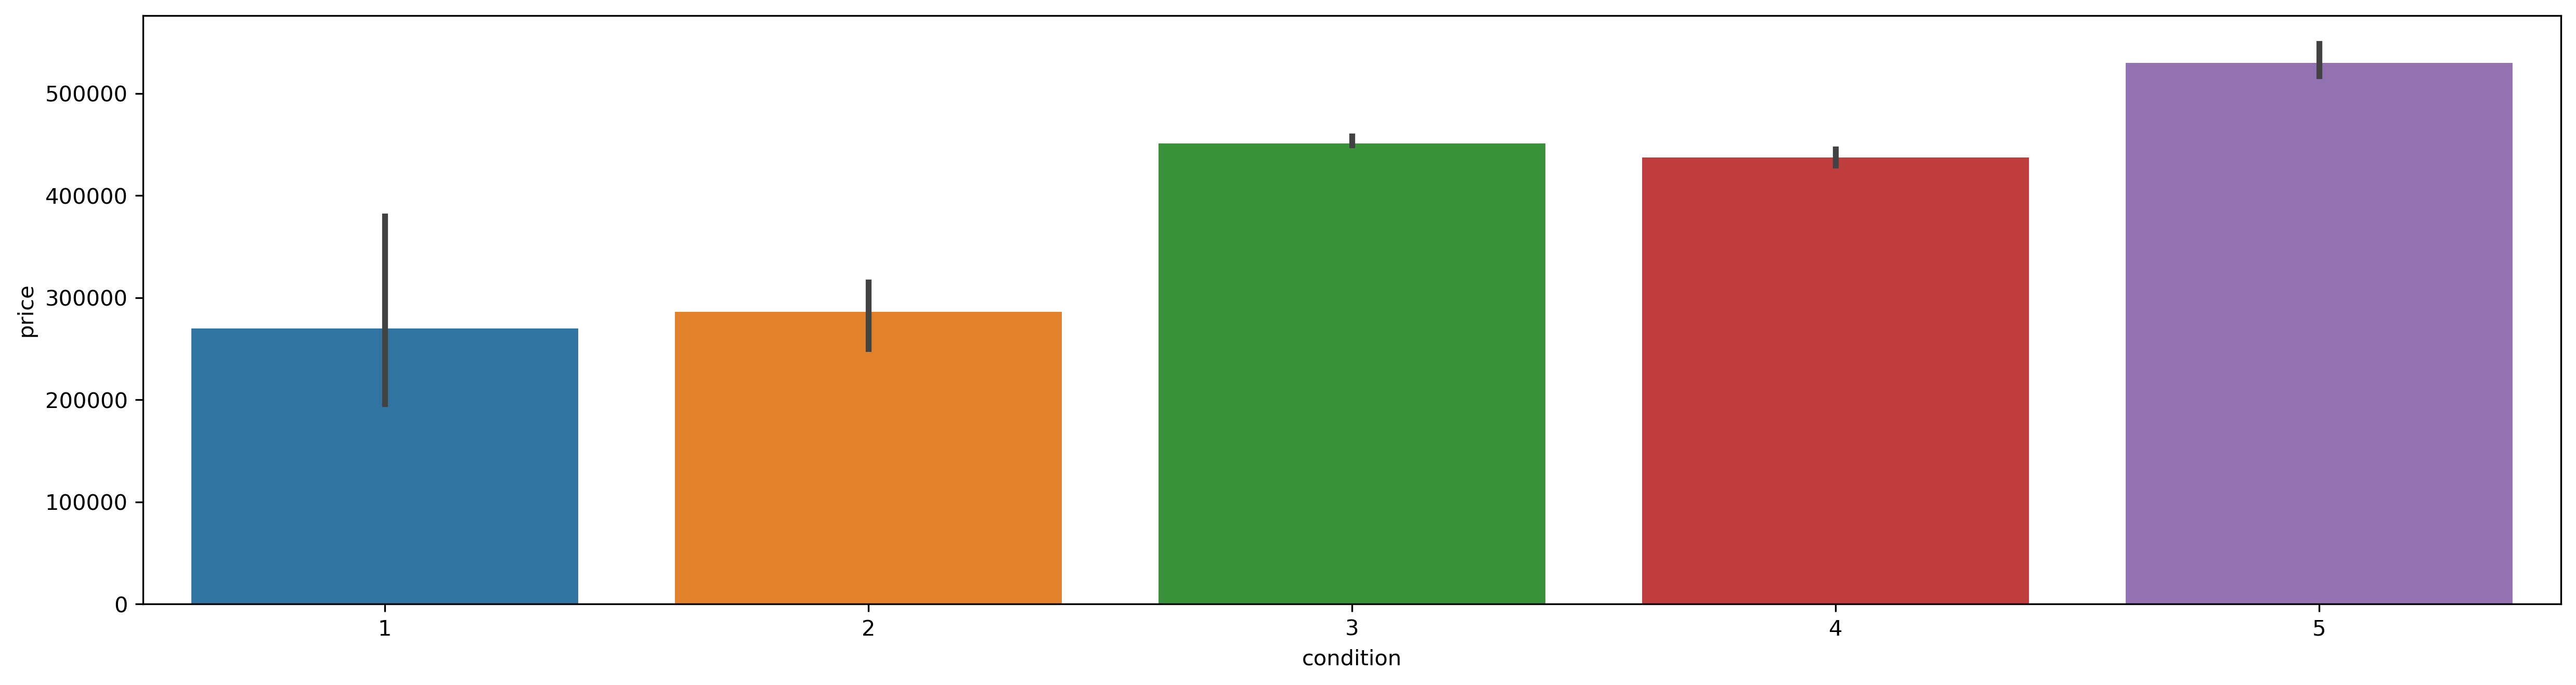

In [23]:
plot_bar_medians(group_by='condition')

We engineer a new feature `'condition bin'` by binning.

In [24]:
condition_bins = [0, 2, 4, 5]
condition_labels = ['1 to 2', '3 to 4', '5']

### `'grade bin'`: binning of `'grade'`

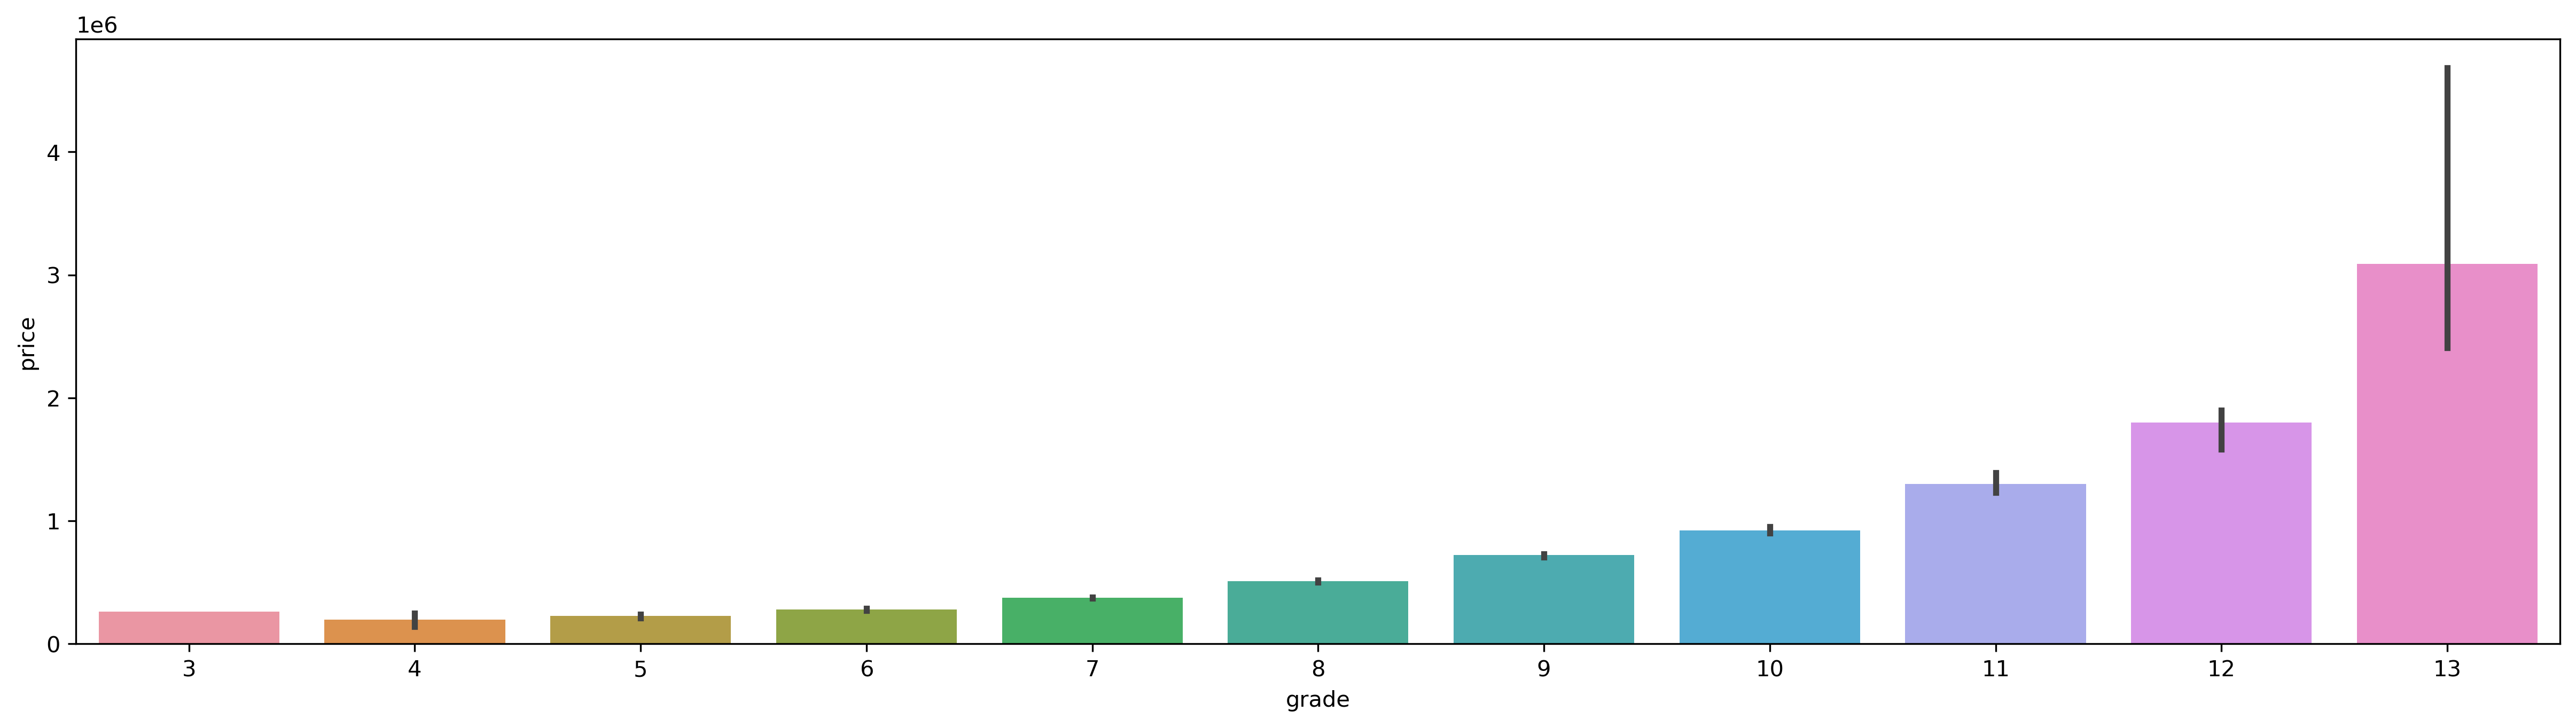

In [25]:
plot_bar_medians(group_by='grade')

We engineer a new feature `'grade bin'` by binning.

In [26]:
grade_bins = [0, 6, 7, 8, 9, 10, 11, 12, 13]
grade_labels = ['3 to 6', '7', '8', '9', '10', '11', '12', '13']

### `'view bin'`: binning of `'view'`

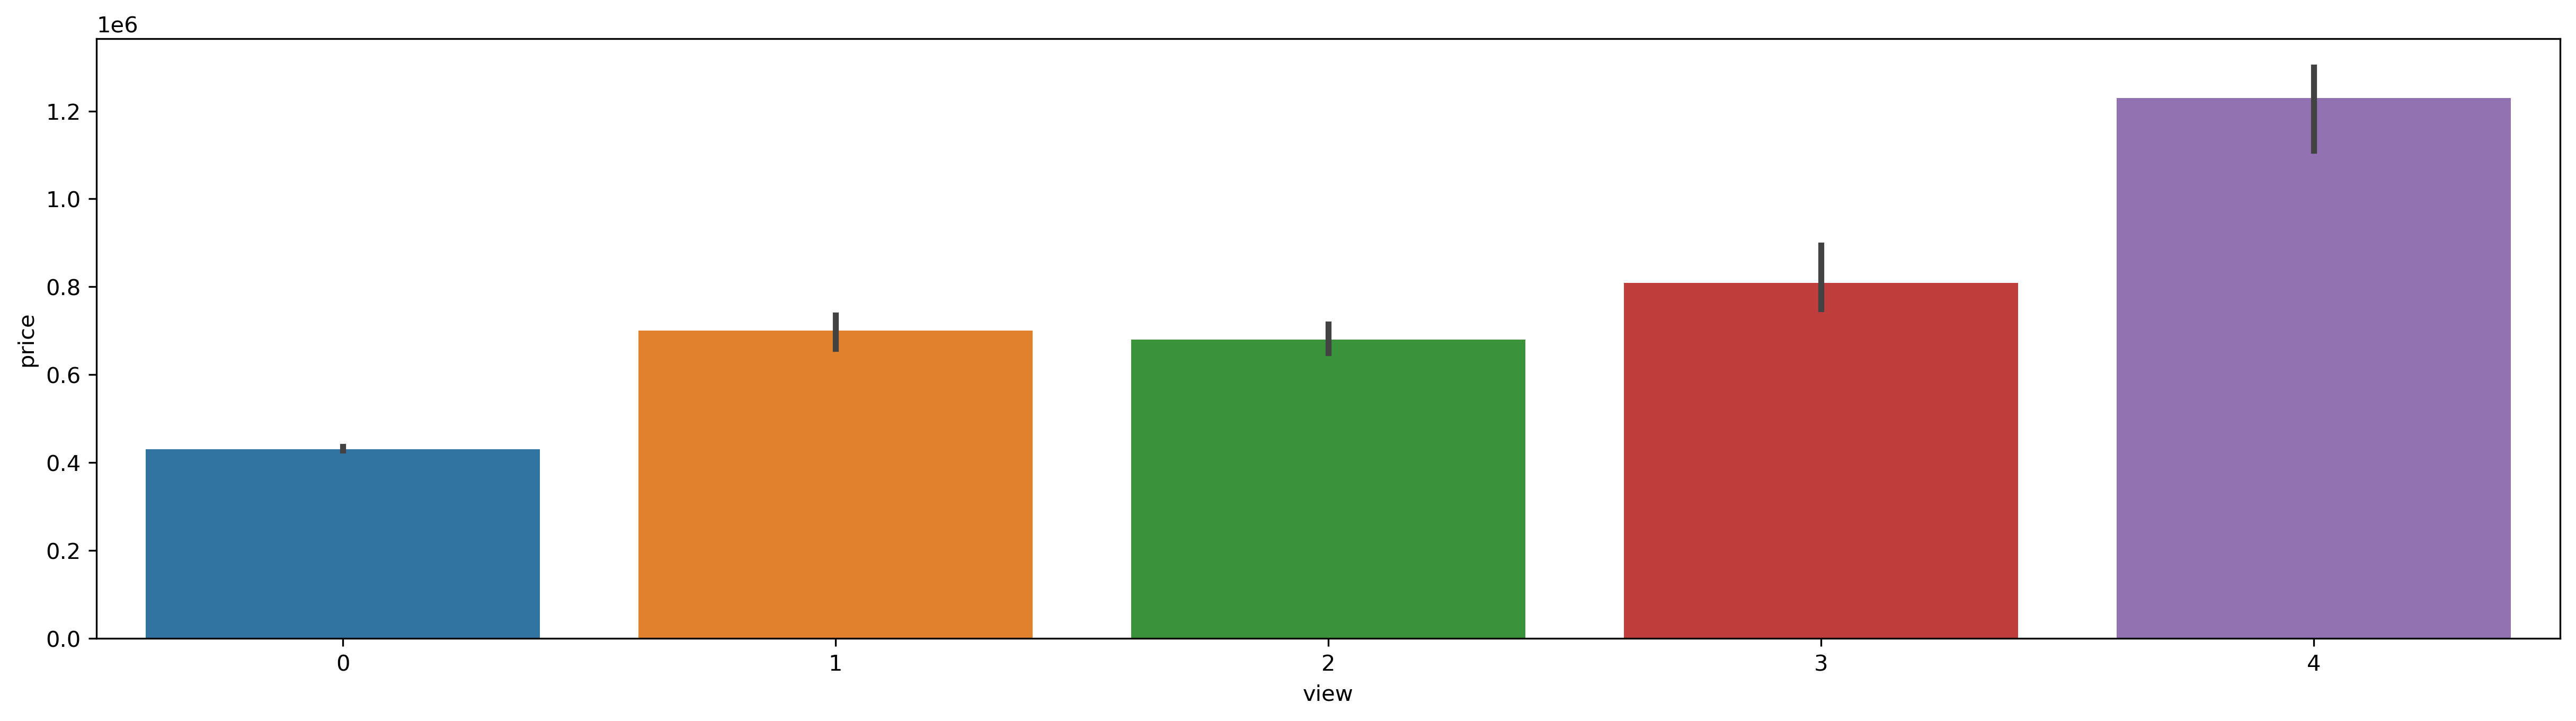

In [27]:
plot_bar_medians(group_by='view')

We engineer a new feature `'view bin'` by binning.

In [28]:
view_bins = [-1, 0.5, 2, 3, 4]
view_labels = ['0', '1 to 2', '3', '4']

### Binner

In [29]:
bin_data = {
    'bedrooms':                   (bedrooms_bins, bedrooms_labels),
    'bathrooms':                  (bathrooms_bins, bathrooms_labels),
    'bathrooms_ratio':            (bathrooms_ratio_bins, bathrooms_ratio_labels),
    'floors':                     (floors_bins, floors_labels),
    ('yr_built', 'decade_built'): (decade_bins, decade_labels),
    'yr_built':                   (yr_built_bins, yr_built_labels),
    'condition':                  (condition_bins, condition_labels),
    'grade':                      (grade_bins, grade_labels),
    'view':                       (view_bins, view_labels)
}

binner = FunctionTransformer(bin_features, kw_args={'bin_data': bin_data})

houses_train = binner.transform(houses_train)

## Identifying categories of values

### `'zipcode cat'`: coarsening of `'zipcode'` 

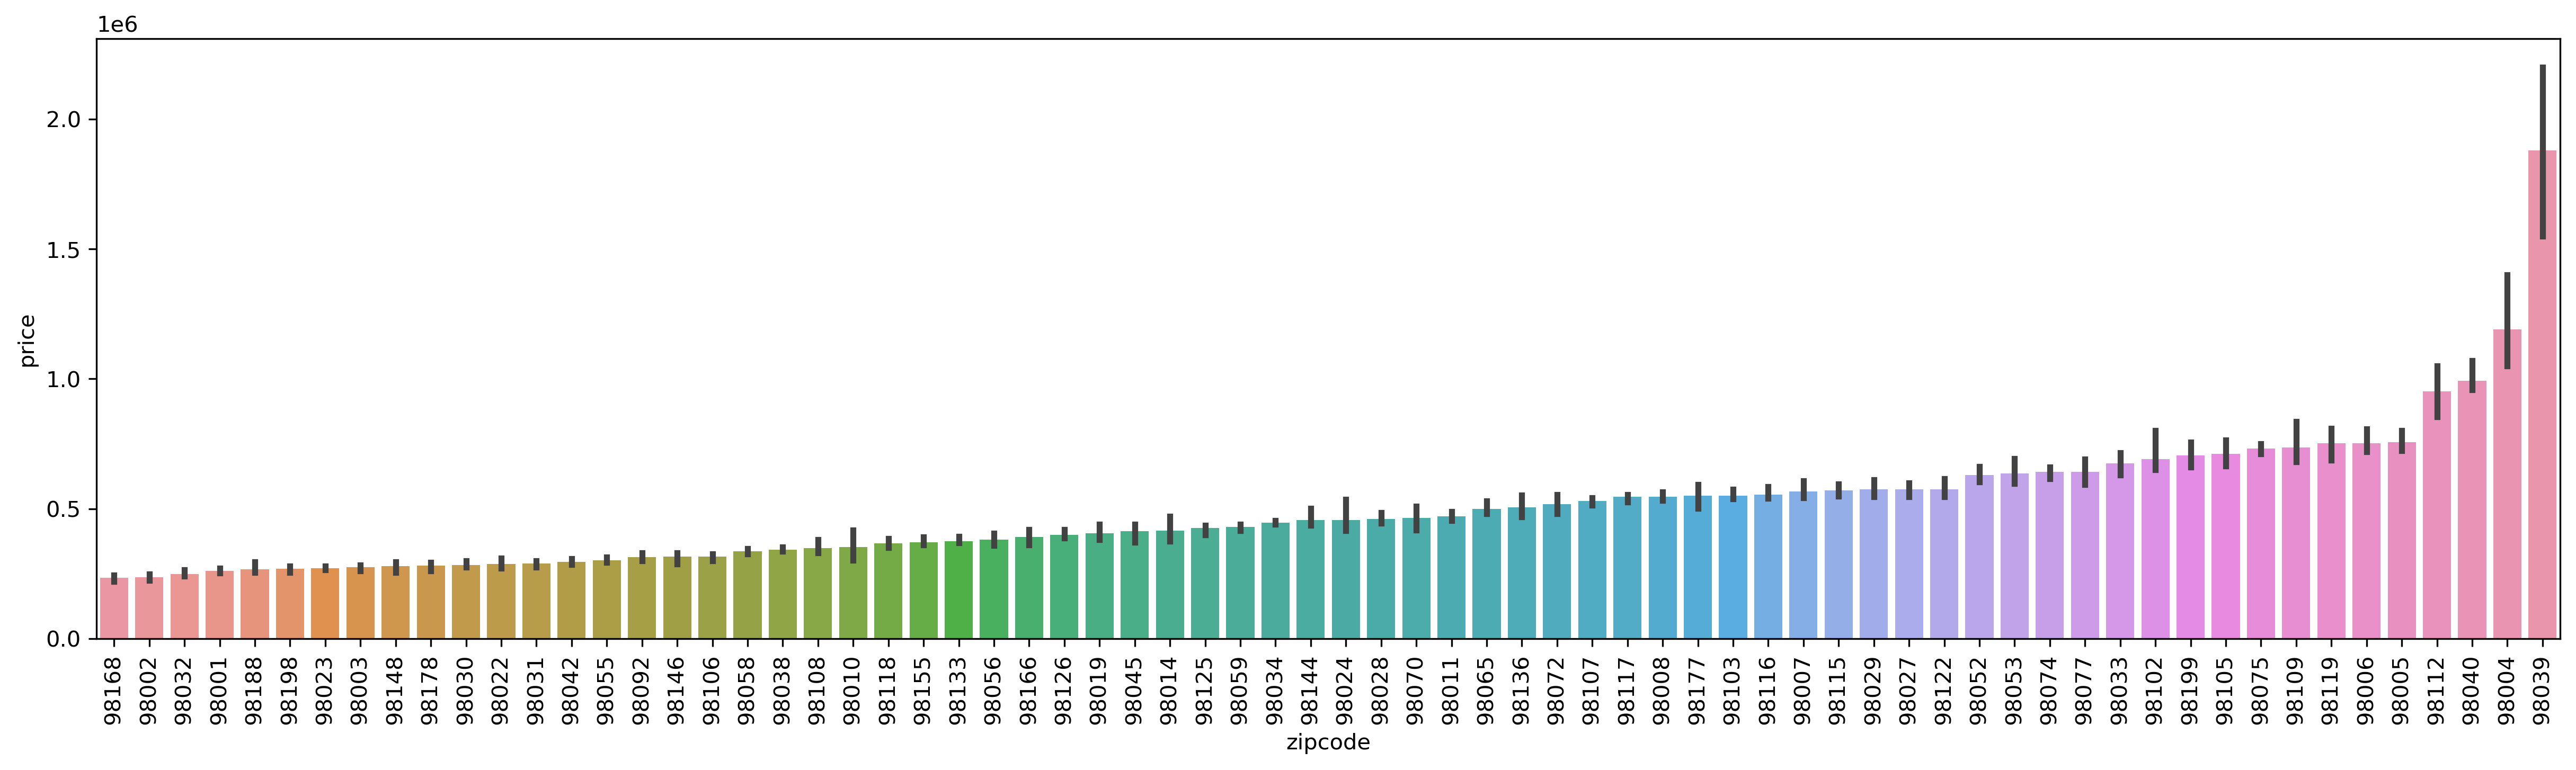

In [30]:
plot_bar_medians(group_by='zipcode', ordered=True, vertical=True)

We engineer a new feature `'zipcode cat'` by coarsening.

In [31]:
zipcode_coarsen = (houses_train.groupby('zipcode')['price'].median()/100000).sort_values().astype('int').map({
    2: 0,
    3: 1,
    4: 2,
    5: 3,
    6: 4,
    7: 5,
    9: 6,
    11: 7,
    18: 8
}).to_dict()

### Coarsener

In [32]:
coarsen_data = {
    'zipcode': zipcode_coarsen
}

coarsener = FunctionTransformer(coarsen_categories, kw_args={'coarsen_data': coarsen_data})

houses_train = coarsener.transform(houses_train)

## Documentation of features

In [33]:
features = features.append(pd.DataFrame([
    {'feature': 'month', 'description': 'month (and year) when object was sold', 'type': 'ordered (categorical)'},
    {'feature': 'room_size', 'description': 'estimator for the mean room size of object',
     'type': 'continuous (numeric)'},
    {'feature': 'base_area', 'description': 'estimator for the base area of object',
     'type': 'continuous (numeric)'},
    {'feature': 'has_basement', 'description': 'indicator for finished basement', 'type': 'boolean'},
    {'feature': 'bathrooms_ratio', 'description': 'estimator for bath share of object',
     'type': 'continuous (numeric)'},
    {'feature': 'is_renovated', 'description': 'indicator for renovated object', 'type': 'boolean'},
    {'feature': 'sqft_living log', 'description': 'logarithm of interior housing living space',
     'type': 'continuous (numeric)'},
    {'feature': 'sqft_above log', 'description': 'logarithm of house area apart from basement',
     'type': 'continuous (numeric)'},
    {'feature': 'room_size log', 'description': 'estimator for logarithm of mean room size',
     'type': 'continuous (numeric)'},
    {'feature': 'base_area log', 'description': 'estimator for logarithm of base area',
     'type': 'continuous (numeric)'},
    {'feature': 'sqft_living15 log',
     'description': 'logarithm of interior housing living space of nearest 15 neighbours',
     'type': 'continuous (numeric)'},
    {'feature': 'bedrooms bin', 'description': 'category of number of bedrooms', 'type': 'ordered (categorical)'},
    {'feature': 'bathrooms bin', 'description': 'category of number of bathrooms',
     'type': 'ordered (categorical)'},
    {'feature': 'bathrooms_ratio bin', 'description': 'category of bath share', 'type': 'ordered (categorical)'},
    {'feature': 'floors bin', 'description': 'category of number of total floors',
     'type': 'ordered (categorical)'},
    {'feature': 'decade_built', 'description': 'decade when house was built', 'type': 'ordered (categorical)'},
    {'feature': 'yr_built bin', 'description': 'category of year when house was built',
     'type': 'ordered (categorical)'},
    {'feature': 'condition bin', 'description': 'category of overall condition', 'type': 'ordered (categorical)'},
    {'feature': 'grade bin', 'description': 'category of overall grade', 'type': 'ordered (categorical)'},
    {'feature': 'view bin', 'description': 'category of overall view', 'type': 'ordered (categorical)'},
    {'feature': 'zipcode cat', 'description': 'category of zipcode of area', 'type': 'nominal (categorical)'}
]).astype('string').set_index('feature'))

## Reordering of features

In [34]:
houses_train.columns

Index(['price', 'date', 'sqft_living', 'sqft_above', 'sqft_basement',
       'sqft_lot', 'sqft_living15', 'sqft_lot15', 'bedrooms', 'bathrooms',
       'floors', 'yr_built', 'yr_renovated', 'lat', 'long', 'zipcode',
       'condition', 'grade', 'view', 'waterfront', 'month', 'room_size',
       'base_area', 'has_basement', 'bathrooms_ratio', 'is_renovated',
       'sqft_living log', 'sqft_above log', 'sqft_basement log',
       'room_size log', 'base_area log', 'sqft_living15 log', 'bedrooms bin',
       'bathrooms bin', 'bathrooms_ratio bin', 'floors bin', 'decade_built',
       'yr_built bin', 'condition bin', 'grade bin', 'view bin',
       'zipcode cat'],
      dtype='object')

In [35]:
columns = ['price', 'date', 'month', 'sqft_living', 'sqft_living log', 'sqft_above', 'sqft_above log',
           'sqft_basement', 'has_basement', 'room_size', 'room_size log', 'base_area', 'base_area log',
           'sqft_lot', 'sqft_living15', 'sqft_living15 log', 'sqft_lot15', 'bedrooms', 'bedrooms bin',
           'bathrooms', 'bathrooms bin', 'bathrooms_ratio', 'bathrooms_ratio bin', 'floors', 'floors bin',
           'yr_built', 'decade_built', 'yr_built bin', 'yr_renovated', 'is_renovated', 'lat', 'long', 'zipcode',
           'zipcode cat', 'condition', 'condition bin', 'grade', 'grade bin', 'view', 'view bin', 'waterfront']

reindexer = FunctionTransformer(reindex_columns, kw_args={'columns': columns})

houses_train = reindexer.transform(houses_train)
features = features.reindex(index=columns[1:])

## Summary

In [36]:
houses_train.sample(5, random_state=0)

,price,date,month,sqft_living,sqft_living log,sqft_above,sqft_above log,sqft_basement,has_basement,room_size,room_size log,base_area,base_area log,sqft_lot,sqft_living15,sqft_living15 log,sqft_lot15,bedrooms,bedrooms bin,bathrooms,bathrooms bin,bathrooms_ratio,bathrooms_ratio bin,floors,floors bin,yr_built,decade_built,yr_built bin,yr_renovated,is_renovated,lat,long,zipcode,zipcode cat,condition,condition bin,grade,grade bin,view,view bin,waterfront
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
8724300010,"548,000.00",2014-09-09,2014-09,"3,420.00",8.14,"2,330.00",7.75,"1,090.00",True,414.55,6.03,"1,710.00",7.44,"5,012.00","2,320.00",7.75,"5,465.00",4,4,3.25,3.25 to 3.5,0.81,0.795 to 1.160,2.00,1.5 to 2.0,2008,2000s,2002 to 2012,2008,True,47.73,-121.98,98019,2,3,3 to 4,10,10,0,0,False
1423400005,"249,950.00",2014-08-15,2014-08,"1,370.00",7.22,"1,370.00",7.22,0.00,False,274.00,5.62,"1,370.00",7.22,"11,658.00","1,080.00",6.99,"9,198.00",3,3,1.00,0.75 to 1,0.33,0.000 to 0.345,1.00,1.0,1958,1950s,1932 to 1971,1958,False,47.46,-122.18,98058,1,4,3 to 4,6,3 to 6,0,0,False
7202330280,"401,000.00",2014-09-22,2014-09,"1,350.00",7.21,"1,350.00",7.21,0.00,False,216.00,5.38,675.00,6.52,"2,839.00","1,650.00",7.41,"3,093.00",3,3,2.25,2.25 to 3,0.75,0.615 to 0.795,2.00,1.5 to 2.0,2003,2000s,2002 to 2012,2003,True,47.68,-122.04,98053,4,3,3 to 4,7,7,0,0,False
1828000230,"498,000.00",2014-07-14,2014-07,"1,620.00",7.39,"1,180.00",7.07,440.00,True,270.00,5.60,"1,620.00",7.39,"8,400.00","2,120.00",7.66,"8,424.00",3,3,2.00,1.25 to 2,0.67,0.615 to 0.795,1.00,1.0,1968,1960s,1932 to 1971,1968,False,47.66,-122.13,98052,4,3,3 to 4,7,7,0,0,False
3342100995,"449,000.00",2014-10-22,2014-10,"1,980.00",7.59,"1,980.00",7.59,0.00,False,264.00,5.58,990.00,6.90,"5,400.00","1,980.00",7.59,"5,400.00",4,4,2.50,2.25 to 3,0.62,0.615 to 0.795,2.00,1.5 to 2.0,1998,1990s,1992 to 2001,1998,True,47.52,-122.21,98056,1,3,3 to 4,8,8,0,0,False


In [37]:
data_type_info(houses_train)

,dtype,n_unique,p_unique,n_na,p_na
price,float64,3036,0.19,0,0.00
date,datetime64[ns],368,0.02,0,0.00
month,category,13,0.00,0,0.00
sqft_living,float64,919,0.06,0,0.00
sqft_living log,float64,919,0.06,0,0.00
sqft_above,float64,831,0.05,0,0.00
sqft_above log,float64,831,0.05,0,0.00
sqft_basement,float64,281,0.02,0,0.00
has_basement,bool,2,0.00,0,0.00
room_size,float64,3640,0.23,0,0.00


In [38]:
features

,description,type
feature,,
date,date when object was sold,date time
month,month (and year) when object was sold,ordered (categorical)
sqft_living,square footage of interior housing living space,continuous (numeric)
sqft_living log,logarithm of interior housing living space,continuous (numeric)
sqft_above,square footage of house apart from basement,continuous (numeric)
sqft_above log,logarithm of house area apart from basement,continuous (numeric)
sqft_basement,square footage of basement,continuous (numeric)
has_basement,indicator for finished basement,boolean
room_size,estimator for the mean room size of object,continuous (numeric)


## Save data

We save the data with engineered features.

In [39]:
houses_train.to_pickle('data/king_county_train_2_engineered.pickle')
features.to_pickle('data/features_1_engineered.pickle')

## Save preprocessor

We construct a preprocessor object and save it for later usage.

In [40]:
preprocessor_engineer = make_pipeline(engineerer, logarithmizer, binner, coarsener)

joblib.dump(preprocessor_engineer, 'objects/preprocessor_engineer.joblib');